In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Load dataset
Here we use a dataset built into Tensorflow - the CIFR Image Dataset. <br>
It contains 60,000 32*32 colored images of 10 different everyday objects (classes), with 6,000 images in each class. <br><br>
The 10 everyday objects/classes are:
- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

In [4]:
# load & split data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context 
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# normalise pixel values to be between 0 & 1
train_images, test_images = train_images/255.0, test_images/255.0
#train_images, test_images = train_images, test_images


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

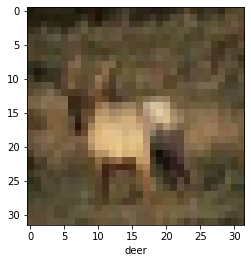

In [5]:
# Let's look at 1 image
IMG_INDEX = 3

plt.imshow(train_images[IMG_INDEX], cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

# Build the model (CNN Architecture)
### a) Convolutional Base

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# 32 = no. of filters
# (3,3) = dimension of each filter
# input_shape = (height, width, depth)
# depth=3 means 3 color channels ie. RGB
model.add(layers.MaxPooling2D(2,2))
# max pooling operation using 2*2 samples with stride of 2
# causes n*n dimensions to be reduced to (n/2)*(n/2) dimensions
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# the 2nd convolutional layer has 64 filters
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

With each max_pooling layer, our dimensions are reduced by half. <br>
With each convolutional layer, we get 2 pixels less since we didn't use padding.
### b) Adding Dense Layers

In [8]:
model.add(layers.Flatten()) # depth of 64 becomes 1 line of 64 values
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10)) # 10 neurons for 10 classes

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

# Compile the Model

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the Model

In [ ]:
history = model.fit(train_images, train_labels, epochs=4,
                    validation_data=(test_images, test_labels))

# Test the Model

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(test_acc)

In [ ]:
# model.save("3a) CNN.h5")
new_model = tf.keras.models.load_model('3a) CNN.h5')

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']
    prediction = model.predict(np.array([image]))
    predicted_class = class_names[np.argmax(prediction)]
    
    show_image(image, class_names[correct_label[0]], predicted_class)

def show_image(img, label, guess):
    plt.figure()
    plt.imshow(img, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()
    print('Actual: ' + label)
    print('Predicted: '+ guess)

def get_number(images):
    while True:
        num = input("Pick a number: ")
        if num.isdigit() and 0<= int(num)<images.shape[0]:
            return int(num)
        else:
            print('Try again...')

num = get_number(test_images)
image = test_images[num]
label = test_labels[num]
predict(new_model, image, label)

<br><br>
# <b>Working with Small Datasets</b> (few thousand)
### 1) Data Augmentation

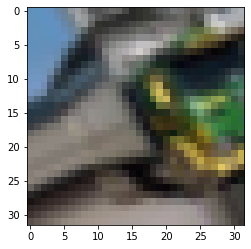

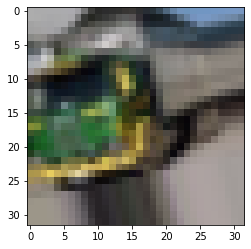

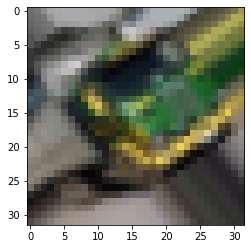

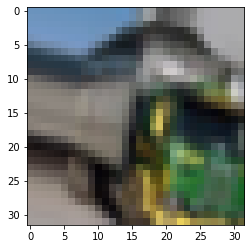

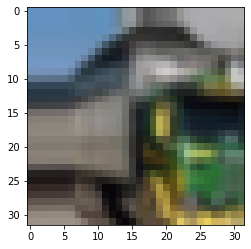

In [4]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Create a data generator object that tranforms images
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Pick 1 image to transform
test_img = train_images[14] 
img = image.img_to_array(test_img) # convert image to numpy array
img = img.reshape((1,) + img.shape) # reshape image

i = 0
for batch in datagen.flow(img, save_prefix='test', save_format='jpeg'):
    plt.figure(i)
    plot = plt.imshow(image.img_to_array(batch[0]))
    i += 1
    if i > 4: break # show just 4 images
plt.show()

### 2. Pretrained Models
Use pretrained models (eg. by Google) as base of our model.

In [2]:
import os
keras = tf.keras

#### Load dataset

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# Split data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load (
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

dog


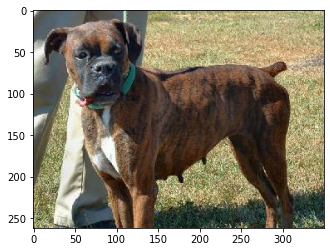

dog


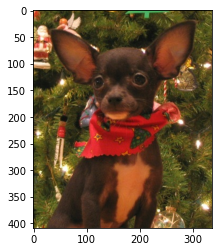

In [7]:
# Create function object that we can use to get labels
get_label_name = metadata.features['label'].int2str

# Display 2 images from dataset
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    print(get_label_name(label))
    plt.show()

#### Data Preprocessing
Since dimension of images are all different, we need to convert them to all the same size.

dog


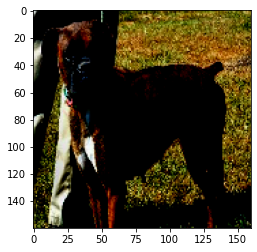

dog


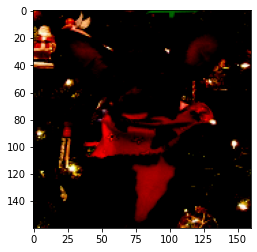

In [8]:
# All images will be resized to 160*160
IMG_SIZE = 160 

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Now we can apply this function to all our images using map
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# Let's look at our images now
for image, label in train.take(2):
    plt.figure()
    plt.imshow(image)
    print(get_label_name(label))
    plt.show()

In [9]:
# Finally we shuffle and batch the images
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

#### Picking a pretrained model
The model we're using as our convolutional base is the <b>MobileNet V2</b> developed at Google. <br>
This model is trained on 1.4 million images and has 1000 different classes. <br><br>
We want to use this model but only its convolutional base. So when loading in the model, we'll specify we don't want to load the top (classification) layer.

In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [11]:
for image, _ in train_batches.take(1):
    pass

print(base_model(image).shape)

(32, 5, 5, 1280)


At this point this base_model will simply output a shape (32, 5, 5, 1280) tensor that is a feature extraction from our original (1, 160, 160, 3) image. The 32 means that we have 32 layers of different filters/features.

#### Freezing the base
Freezing refers to disabling the training property of a layer. It means we won't make any changes to the weights of any layers that are frozen during training. This prevents changing the convolutional base that already has learned weights.

In [12]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

We see now the "Trainable params" are 0.
#### Adding our classifier
Now we build our classifier upon the base layer. <br>
Instead of flattening the feature map of the base layer we will use a global average pooling layer that will average the entire 5x5 area of each 2D feature map and return to us a single 1D 1280 element vector per filter.

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Now we add a prediction layer that will be a single dense neuron. We can do this because we only have 2 classes to predict for.

In [14]:
prediction_layer = keras.layers.Dense(1)

Now we combine these layers together in the model.

In [15]:
model2 = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


#### Compile model

In [16]:
# Learning Rate = how much are we allowed to modify weights & biases of this network
base_learning_rate = 0.0001
# we made it very low cuz we don't want to make any major changes since the model is already pretrained

model2.compile(
    optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

c:\Users\HP\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


#### Train model

In [23]:
# We can evaluate our model right now to see how it goes before training it on our new images
initial_epochs = 3
validation_steps = 20

loss0, accuracy0 = model2.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 13s 477ms/step - loss: 0.6059 - accuracy: 0.6156


We can see the accuracy is close to 50%, like the model's merely guessing. This is normal since we haven't trained the model.

In [18]:
# Now we train our model ie. modify weights & biases of the last 2 layers
history = model2.fit(
    train_batches,
    epochs=initial_epochs,
    validation_data=validation_batches
)
acc = history.history['accuracy']
print(acc)

Epoch 1/3


KeyboardInterrupt: 

After training our model, it's accuracy should be much closer to 100%.

#### Test model

In [82]:
# model2.save("3b) dog_vs_cats.h5")
new_model2 = tf.keras.models.load_model('3b) dog_vs_cats.h5')

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label):
    class_names = ['cat', 'dog']
    prediction = model.predict(np.array([image]))
    predicted_class = "dog" if (prediction>0) else  "cat" if (prediction<0) else "indeterminate"

    show_image(image, class_names[correct_label], predicted_class)

def show_image(img, label, guess):
    plt.figure()
    plt.imshow(img, cmap=plt.cm.binary)
    plt.colorbar()
    plt.grid(False)
    plt.show()
    print('Actual: ' + label)
    print('Predicted: '+ guess)

def resize(image):
    IMG_SIZE = 160
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

def retrieve(dataset, index):
    i = 0
    for image, label in dataset.take(index+1):
        if (i==index):
            return image, label
        i += 1

def get_number(size):
    while True:
        num = input("Pick a number: ")
        if num.isdigit() and 0<= int(num)<size:
            return int(num)
        else:
            print('Try again...')

In [84]:
print("accuracy:", new_model2.evaluate(test_batches, steps = 20)[1])

20/20 [==============================] - 14s 602ms/step - loss: 0.0698 - accuracy: 0.9781
accuracy: 0.9781249761581421


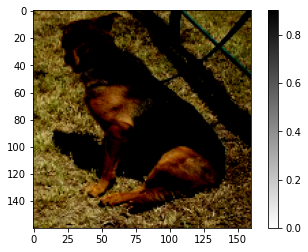

Actual: dog
Predicted: dog


In [85]:
ds_size = sum(1 for _ in raw_train)
num = get_number(ds_size)
image, label = retrieve(raw_train, num)
image = resize(image)
predict(new_model2, image, label)